In [1]:
library('pROC')
library('IRdisplay')
library('lme4')
library('Hmisc')
library('MLmetrics')
library('ggExtra')

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: Matrix

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units



Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall




In [5]:
# run after Error Prediction Model - Data Preparation, where wordLevelChanges.csv is built
# Note that this notebook is in R, whereas data preparation was in Python

In [2]:
wdfs = read.csv('output/wordLevelChanges.csv', stringsAsFactors=F)
wdfs$change = sapply(wdfs$code, function(x){
    if (x == 'M'){
        return(0)
    } else { 
        return(1)
    }
})
wdfs$one =1

In [3]:
names(wdfs)

[1] "bnc_unigram_index"                                  
  [2] "bnc_unigram_prob"                                   
  [3] "bnc_unigram_word"                                   
  [4] "bnc_trigram_index"                                  
  [5] "bnc_trigram_prob"                                   
  [6] "bnc_trigram_word"                                   
  [7] "roark_scores_prefix"                                
  [8] "roark_scores_word"                                  
  [9] "roark_scores_prefix.1"                              
 [10] "roark_scores_srprsl"                                
 [11] "roark_scores_SynSp"                                 
 [12] "roark_scores_LexSp"                                 
 [13] "roark_scores_ambig"                                 
 [14] "roark_scores_open"                                  
 [15] "roark_scores_rernk"                                 
 [16] "roark_scores_toprr"                                 
 [17] "roark_scores_stps"                                  
 [18] "big_lm_scores_Unnamed..0"                           
 [19] "big_lm_scores_prob"                                 
 [20] "big_lm_scores_word"                                 
 [21] "kenlm_scores_prob"                                  
 [22] "kenlm_scores_preceding"                             
 [23] "kenlm_scores_unk"                                   
 [24] "kenlm_scores_word"                                  
 [25] "gpt2_normal_scores_prob"                            
 [26] "gpt2_normal_scores_word"                            
 [27] "gpt2_medium_scores_prob"                            
 [28] "gpt2_medium_scores_word"                            
 [29] "bert_scores_prob"                                   
 [30] "bert_scores_word"                                   
 [31] "bart_scores_prob"                                   
 [32] "bart_scores_word"                                   
 [33] "sCounter"                                           
 [34] "sentence_index"                                     
 [35] "word"                                               
 [36] "code"                                               
 [37] "input_subject"                                      
 [38] "output_subject"                                     
 [39] "conc_bigram"                                        
 [40] "conc_conc_m"                                        
 [41] "conc_conc_sd"                                       
 [42] "conc_unknown"                                       
 [43] "conc_total"                                         
 [44] "conc_percent_known"                                 
 [45] "conc_subtlex"                                       
 [46] "conc_dom_pos"                                       
 [47] "kpm_alternative_spelling"                           
 [48] "kpm_freq_pm"                                        
 [49] "kpm_dom_pos_subtlex"                                
 [50] "kpm_nletters"                                       
 [51] "kpm_nphon"                                          
 [52] "kpm_nsyll"                                          
 [53] "kpm_lemma_highest_pos"                              
 [54] "kpm_aoa_kup"                                        
 [55] "kpm_perc_known"                                     
 [56] "kpm_aoa_kup_lem"                                    
 [57] "kpm_perc_known_lem"                                 
 [58] "kpm_aoa_bird_lem"                                   
 [59] "kpm_aoa_bristol_lem"                                
 [60] "kpm_aoa_cort_lem"                                   
 [61] "kpm_aoa_schock"                                     
 [62] "pic_ipa"                                            
 [63] "pic_ipa_ss_array"                                   
 [64] "pic_ipa_ss"                                         
 [65] "pic_ipa_n"                                          
 [66] "pic_ortho"                                          
 [67] "pic_ortho_ss_array"                

In [3]:
# convert log probabilities to surprisals
wdfs$bnc_unigram_prob = -1 * wdfs$bnc_unigram_prob
wdfs$bnc_trigram_prob = -1 * wdfs$bnc_trigram_prob
wdfs$kenlm_scores_prob = -1 * wdfs$kenlm_scores_prob
wdfs$big_lm_scores_prob = -1 * wdfs$big_lm_scores_prob
wdfs$gpt2_normal_scores_prob = -1 * wdfs$gpt2_normal_scores_prob
wdfs$gpt2_medium_scores_prob = -1 * wdfs$gpt2_medium_scores_prob
wdfs$bert_scores_prob = -1 * wdfs$bert_scores_prob
wdfs$bart_scores_prob = -1 * wdfs$bart_scores_prob

In [4]:
wdfs[1,c('bnc_unigram_prob','bnc_trigram_prob','kenlm_scores_prob','big_lm_scores_prob',
        'gpt2_normal_scores_prob', 'gpt2_medium_scores_prob', 'bert_scores_prob', 'bart_scores_prob')]

,bnc_unigram_prob,bnc_trigram_prob,kenlm_scores_prob,big_lm_scores_prob,gpt2_normal_scores_prob,gpt2_medium_scores_prob,bert_scores_prob,bart_scores_prob
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,3.310068,2.994068,3.516777,3.202744,3.570354,3.225354,0.3260236,1.289798


In [5]:
dim(wdfs)

[1] 27290   199

[ ] part of speech  
[X] number of syllables: kpm_nsyll  
[X] word length: kpm_nphon  
[X] aoa_rating: kpm_aoa_kup  
[X] concreteness: conc_conc_m  
[X] phonological neighborhood density: pld20  
[X] contextual diversity: Need Subtlexus: SUBTLCD  

random effects structure
https://www4.stat.ncsu.edu/~reich/ABA/code/DICmixed

In [6]:
wdfs

bnc_unigram_index,bnc_unigram_prob,bnc_unigram_word,bnc_trigram_index,bnc_trigram_prob,bnc_trigram_word,roark_scores_prefix,roark_scores_word,roark_scores_prefix.1,roark_scores_srprsl,⋯,initial_gpt2_medium_probability_quartile,initial_bert_probability,initial_bert_probability_rank,initial_bert_probability_quartile,initial_bart_probability,initial_bart_probability_rank,initial_bart_probability_quartile,thread_id,change,one
<int>,<dbl>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>
0,3.310068,each,0,2.994068,each,pfix:1,each,6.566,2.851578,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
1,7.309903,nonfiction,1,8.412464,nonfiction,pfix:2,nonfiction,18.290,5.091669,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,1,1
2,3.631093,book,2,3.756868,book,pfix:3,book,28.519,4.442398,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
3,2.600407,has,3,2.253614,has,pfix:4,has,32.402,1.686800,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
4,1.681165,a,4,1.317157,a,pfix:5,a,35.256,1.239042,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
5,3.737589,call,5,3.763689,call,pfix:6,call,44.218,3.892147,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
6,3.321531,number,6,3.708286,number,pfix:7,number,53.366,3.972926,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1
7,2.162270,on,7,2.029635,on,pfix:8,on,58.319,2.151495,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,1,1
8,2.804867,its,8,2.394903,its,pfix:9,its,62.220,1.693748,⋯,1,-13.29464,0,0,-16.23387,13,1,0_0,0,1


In [7]:
# interpolate missing values in the input
fixed_effects = c('one','word','bnc_unigram_prob', 'bnc_trigram_prob', 'roark_scores_SynSp', 
'roark_scores_LexSp', 'big_lm_scores_prob', 'kenlm_scores_prob','sCounter', 
'kpm_aoa_kup','kpm_nphon', 'kpm_nsyll','conc_conc_m','pld20', 'SUBTLCD', 
'normalized_biglm_probability', 'normalized_WSJ_Roark_Negative.Log.Probability',
'normalized_BNC_KNN_unigramProb', 'normalized_BNC_KNN_trigramProb',
'normalized_kenlm_probability', 'normalized_bllip_probability', 
'normalized_bllip_wsj_probability', 'normalized_mikolov_wsj_probability','pic_ipa_ss','kenlm_scores_prob',
                 'normalized_gpt2_normal_probability', 'normalized_gpt2_medium_probability', 'normalized_bert_probability',
                 'normalized_bart_probability',
                 'bert_scores_prob', 'gpt2_normal_scores_prob', 'gpt2_medium_scores_prob', 'bart_scores_prob')

for(fixed_effect in fixed_effects){
    print(paste(fixed_effect, 'missing', length(which(is.na(wdfs[,fixed_effect]))), 'observations'))
  wdfs[is.na(wdfs[,fixed_effect]), fixed_effect] <- mean(wdfs[,fixed_effect], na.rm = TRUE)
}

[1] "one missing 0 observations"
[1] "word missing 0 observations"


Warning message in mean.default(wdfs[, fixed_effect], na.rm = TRUE):
“argument is not numeric or logical: returning NA”


[1] "bnc_unigram_prob missing 0 observations"
[1] "bnc_trigram_prob missing 0 observations"
[1] "roark_scores_SynSp missing 0 observations"
[1] "roark_scores_LexSp missing 0 observations"
[1] "big_lm_scores_prob missing 0 observations"
[1] "kenlm_scores_prob missing 0 observations"
[1] "sCounter missing 0 observations"
[1] "kpm_aoa_kup missing 5562 observations"
[1] "kpm_nphon missing 435 observations"
[1] "kpm_nsyll missing 435 observations"
[1] "conc_conc_m missing 2457 observations"
[1] "pld20 missing 253 observations"
[1] "SUBTLCD missing 45 observations"
[1] "normalized_biglm_probability missing 0 observations"
[1] "normalized_WSJ_Roark_Negative.Log.Probability missing 0 observations"
[1] "normalized_BNC_KNN_unigramProb missing 0 observations"
[1] "normalized_BNC_KNN_trigramProb missing 0 observations"
[1] "normalized_kenlm_probability missing 0 observations"
[1] "normalized_bllip_probability missing 0 observations"
[1] "normalized_bllip_wsj_probability missing 0 observations"
[1]

# Fixed Effects Logistic Regression

In [8]:
fixed_effects

[1] "one"                                          
 [2] "word"                                         
 [3] "bnc_unigram_prob"                             
 [4] "bnc_trigram_prob"                             
 [5] "roark_scores_SynSp"                           
 [6] "roark_scores_LexSp"                           
 [7] "big_lm_scores_prob"                           
 [8] "kenlm_scores_prob"                            
 [9] "sCounter"                                     
[10] "kpm_aoa_kup"                                  
[11] "kpm_nphon"                                    
[12] "kpm_nsyll"                                    
[13] "conc_conc_m"                                  
[14] "pld20"                                        
[15] "SUBTLCD"                                      
[16] "normalized_biglm_probability"                 
[17] "normalized_WSJ_Roark_Negative.Log.Probability"
[18] "normalized_BNC_KNN_unigramProb"               
[19] "normalized_BNC_KNN_trigramProb"               
[20] "normalized_kenlm_probability"                 
[21] "normalized_bllip_probability"                 
[22] "normalized_bllip_wsj_probability"             
[23] "normalized_mikolov_wsj_probability"           
[24] "pic_ipa_ss"                                   
[25] "kenlm_scores_prob"                            
[26] "normalized_gpt2_normal_probability"           
[27] "normalized_gpt2_medium_probability"           
[28] "normalized_bert_probability"                  
[29] "normalized_bart_probability"                  
[30] "bert_scores_prob"                             
[31] "gpt2_normal_scores_prob"                      
[32] "gpt2_medium_scores_prob"                      
[33] "bart_scores_prob"

In [9]:
# basic fixed effects logistic regression

wdf = wdfs[,fixed_effects]
wdf$changed = as.numeric(wdfs$code != 'M')
model <- glm(changed ~ bnc_unigram_prob + bnc_trigram_prob + roark_scores_LexSp +  roark_scores_SynSp
+ big_lm_scores_prob + bert_scores_prob + gpt2_normal_scores_prob + gpt2_medium_scores_prob
             + bart_scores_prob
             + sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m
, family=binomial(link='logit'),data=wdf)

In [10]:
summary(model)


Call:
glm(formula = changed ~ bnc_unigram_prob + bnc_trigram_prob + 
    roark_scores_LexSp + roark_scores_SynSp + big_lm_scores_prob + 
    bert_scores_prob + gpt2_normal_scores_prob + gpt2_medium_scores_prob + 
    bart_scores_prob + sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + 
    conc_conc_m, family = binomial(link = "logit"), data = wdf)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8597  -0.6278  -0.5202  -0.4274   2.4919  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -2.424535   0.085632 -28.313  < 2e-16 ***
bnc_unigram_prob         0.004476   0.033866   0.132   0.8948    
bnc_trigram_prob         0.157931   0.022202   7.113 1.13e-12 ***
roark_scores_LexSp      -0.041612   0.019117  -2.177   0.0295 *  
roark_scores_SynSp       0.117520   0.026241   4.478 7.52e-06 ***
big_lm_scores_prob       0.115595   0.019691   5.870 4.35e-09 ***
bert_scores_prob         0.140056   0.016492   8.492  < 2e

Setting levels: control = 0, case = 1

Setting direction: controls < cases



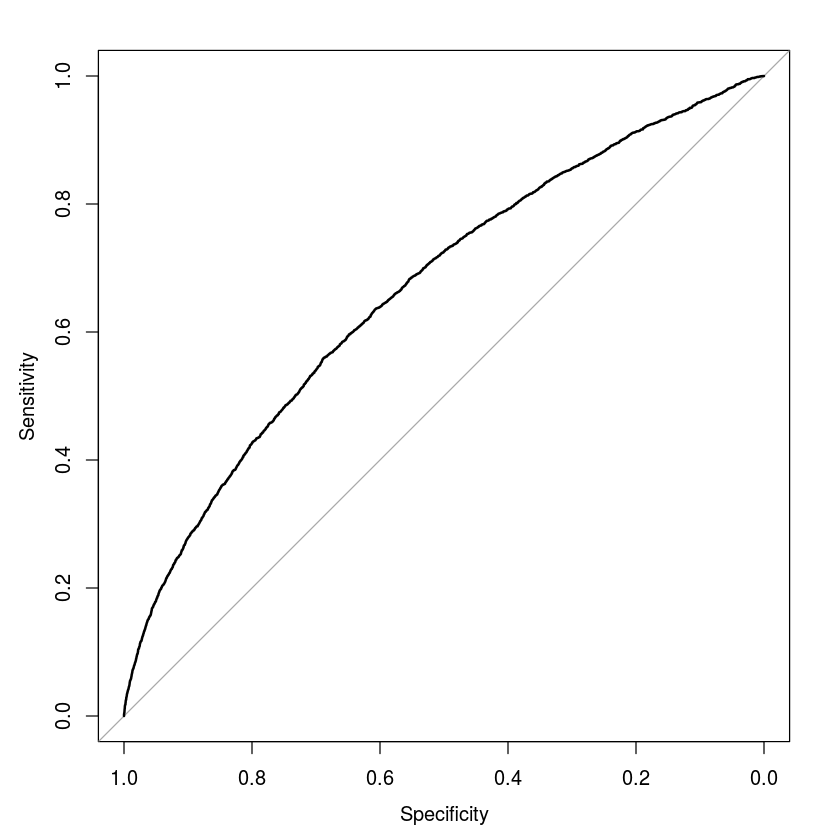

In [11]:
wdfs$predicted = predict(model, wdf, type='response')
df = data.frame(prob=wdfs$predicted, change=wdfs$change)
g <- roc(change ~prob, data = df)
plot(g)    

In [12]:
auc(g)

Area under the curve: 0.6664

In [13]:
colorizeVector = function(vector){
    colorramp = colorRampPalette(c("green", "red"))(n = 101)
    quantiles = quantile(vector, probs=seq(0,1,.01), na.rm=T)
    percentile_limits = sapply(vector, function(x){
        which.max(x <= quantiles)	
    })
    percentile = sapply(percentile_limits, function(x){ifelse(length(x) > 0, x, NA)})
    colors = colorramp[percentile]
    return(colors)
}
wdfs$color = colorizeVector(wdfs$predicted)

colorizeSentence = function(df, sentenceIndex, format = 'HTML'){
    sentence = subset(df, sentence_index == sentenceIndex)
    sentence = sentence[order(sentence$bnc_unigram_index),]
    if (format =='HTML'){
        html_pieces = paste0('<font color="',sentence$color,'">',sentence$word, '</font>')    
        return(paste(html_pieces, collapse =' '))
    } else if (format == 'latex'){
        latex_pieces = paste0('\\textcolor[HTML]{',gsub('#','',sentence$color),'}{',
                              sentence$word,'}')
        #{\color[HTML]{color}text}
        return(paste(latex_pieces, collapse =' '))
    }
}

colorizeSentence(wdfs,1661,'latex')
display_html(colorizeSentence(wdfs,1661))

[1] "\\textcolor[HTML]{44BA00}{you} \\textcolor[HTML]{0CF200}{can} \\textcolor[HTML]{1EE000}{see} \\textcolor[HTML]{5BA300}{that} \\textcolor[HTML]{B54900}{they} \\textcolor[HTML]{42BC00}{have} \\textcolor[HTML]{ED1100}{time} \\textcolor[HTML]{609E00}{to} \\textcolor[HTML]{C43A00}{run}"

you can see that they have time to run

# Mixed Effects Logistic Regression Model

In [14]:
print(names(wdf))
print(nrow(wdf))

 [1] "one"                                          
 [2] "word"                                         
 [3] "bnc_unigram_prob"                             
 [4] "bnc_trigram_prob"                             
 [5] "roark_scores_SynSp"                           
 [6] "roark_scores_LexSp"                           
 [7] "big_lm_scores_prob"                           
 [8] "kenlm_scores_prob"                            
 [9] "sCounter"                                     
[10] "kpm_aoa_kup"                                  
[11] "kpm_nphon"                                    
[12] "kpm_nsyll"                                    
[13] "conc_conc_m"                                  
[14] "pld20"                                        
[15] "SUBTLCD"                                      
[16] "normalized_biglm_probability"                 
[17] "normalized_WSJ_Roark_Negative.Log.Probability"
[18] "normalized_BNC_KNN_unigramProb"               
[19] "normalized_BNC_KNN_trigramProb"         

In [15]:
# add residuals 
wdf$resid_bnc_trigram_prob = lm(bnc_trigram_prob ~ bnc_unigram_prob, data=wdf)$residuals

# Note to self: p. 33 of the paper.
for (structuredModel in c('roark_scores_SynSp','big_lm_scores_prob','kenlm_scores_prob',
                          'gpt2_normal_scores_prob', 'gpt2_medium_scores_prob', 'bert_scores_prob',
                         'bart_scores_prob')){
    wdf[[paste0('resid_',structuredModel)]] = lm(as.formula(paste0(structuredModel, 
        ' ~ bnc_trigram_prob + bnc_unigram_prob')), data=wdf)$residuals
}

In [16]:
wdf$subject_id = as.factor(wdfs$user)
wdf$upstream_subject_id = as.factor(wdfs$upstream_subject_id)

mixed_model <- glmer(changed ~ bnc_unigram_prob + resid_bnc_trigram_prob + resid_roark_scores_SynSp 
+ resid_big_lm_scores_prob + resid_kenlm_scores_prob
                     + resid_gpt2_normal_scores_prob + resid_gpt2_medium_scores_prob + resid_bert_scores_prob
                     + resid_bart_scores_prob
                     + sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 
+ (1|subject_id) + (1|upstream_subject_id)
,family=binomial(link='logit'),data=wdf, control=glmerControl(optimizer="bobyqa",
                            optCtrl=list(maxfun=2e5)))

In [22]:
# how useful is knowing the probability of the sentence -- takes forever to run
#+ normalized_biglm_probability + normalized_WSJ_Roark_Negative.Log.Probability 
#+ normalized_BNC_KNN_unigramProb + normalized_BNC_KNN_trigramProb 
#+ normalized_kenlm_probability + normalized_bllip_probability
#+ normalized_bllip_wsj_probability + normalized_mikolov_wsj_probability        

In [17]:
summary(mixed_model)


Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
changed ~ bnc_unigram_prob + resid_bnc_trigram_prob + resid_roark_scores_SynSp +  
    resid_big_lm_scores_prob + resid_kenlm_scores_prob + resid_gpt2_normal_scores_prob +  
    resid_gpt2_medium_scores_prob + resid_bert_scores_prob +  
    resid_bart_scores_prob + sCounter + kpm_aoa_kup + kpm_nphon +  
    kpm_nsyll + conc_conc_m + pld20 + (1 | subject_id) + (1 |  
    upstream_subject_id)
   Data: wdf
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
 23707.0  23854.8 -11835.5  23671.0    27272 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2342 -0.4664 -0.3669 -0.2796  4.8887 

Random effects:
 Groups              Name        Variance Std.Dev.
 subject_id          (Intercept) 0.06709  0.2590  
 upstream_subject_id (Intercept) 0.13775  0.3712  
Number of obs: 2729

In [18]:
# COM: context-only model
context_only_model <- glmer(changed ~ bnc_unigram_prob + resid_bnc_trigram_prob + resid_roark_scores_SynSp 
+ resid_big_lm_scores_prob + resid_kenlm_scores_prob + resid_gpt2_normal_scores_prob + resid_gpt2_medium_scores_prob + resid_bert_scores_prob
                     + resid_bart_scores_prob + (1|subject_id) + (1|upstream_subject_id)
,family=binomial(link='logit'),data=wdf, control=glmerControl(optimizer="bobyqa",
                            optCtrl=list(maxfun=2e5)))
wdfs$com_predicted = predict(context_only_model, wdf, type='response', re.form=NA)
df = data.frame(prob=wdfs$com_predicted, change=wdfs$change)
g_com <- roc(change ~ prob, data = df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [19]:
# SOM: structure only model
structure_only_model <- glmer(changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 
+ (1|subject_id) + (1|upstream_subject_id)
,family=binomial(link='logit'),data=wdf, control=glmerControl(optimizer="bobyqa",
                            optCtrl=list(maxfun=2e5)))
wdfs$som_predicted = predict(structure_only_model, wdf, type='response', re.form=NA)
df = data.frame(prob=wdfs$som_predicted, change=wdfs$change)
g_som <- roc(change ~prob, data = df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [20]:
print('structure_only_model')
print(AIC(structure_only_model))
print('context_only_model')
print(AIC(context_only_model))
print('full model')
print(AIC(mixed_model))

[1] "structure_only_model"
[1] 24927.71
[1] "context_only_model"
[1] 24024.84
[1] "full model"
[1] 23706.99


In [21]:
wdfs$me_predicted = predict(mixed_model, wdf, type='response', re.form=NA)
df = data.frame(prob=wdfs$me_predicted, change=wdfs$change)
g <- roc(change ~prob, data = df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



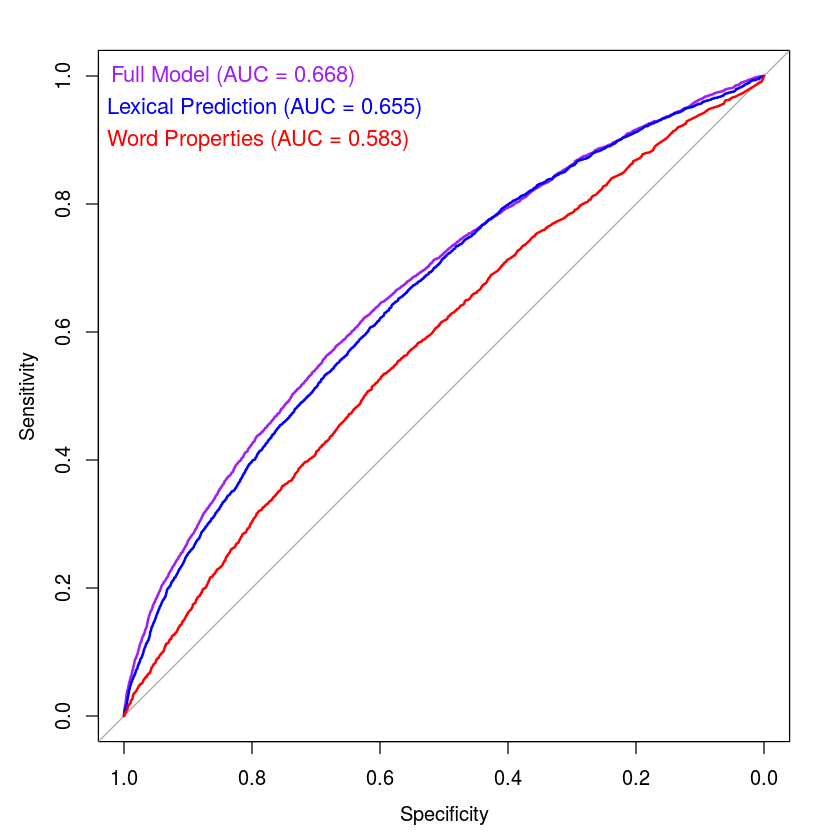

In [22]:
plot(g, col='purple')
text(x = .83, y = 1, labels = paste('Full Model (AUC = ',
      round(auc(g), 3),')', sep=''), cex = 1.1, col = 'purple')
plot(g_com, add=TRUE, col='blue')
text(x = .78, y = .95, labels = paste('Lexical Prediction (AUC = ',
      round(auc(g_com), 3),')', sep=''), cex = 1.1, col = 'blue')
plot(g_som, add=TRUE, col='red')
text(x = .79, y = .9, labels = paste('Word Properties (AUC = ',
    round(auc(g_som), 3),')', sep=''), cex = 1.1, col = 'red')


In [23]:
# get all ROCs on the same curve
pdf('figures/roc_comparison.pdf')
plot(g, col='purple')
text(x = .83, y = 1, labels = paste('Full Model (AUC = ',
      round(auc(g), 3),')', sep=''), cex = 1.1, col = 'purple')
plot(g_com, add=TRUE, col='blue')
text(x = .78, y = .95, labels = paste('Lexical Prediction (AUC = ',
      round(auc(g_com), 3),')', sep=''), cex = 1.1, col = 'blue')
plot(g_som, add=TRUE, col='red')
text(x = .79, y = .9, labels = paste('Word Properties (AUC = ',
    round(auc(g_som), 3),')', sep=''), cex = 1.1, col = 'red')
dev.off()

png 
  2

### Compare the Performance of Each Language Model

In [24]:
lm_predictors = c('bnc_unigram_prob','bnc_trigram_prob','roark_scores_SynSp', 
    'big_lm_scores_prob','kenlm_scores_prob', 'gpt2_normal_scores_prob', 'gpt2_medium_scores_prob', 'bert_scores_prob', 'bart_scores_prob')

lm_nat_lang_names = c('BNC / Unigram','BNC / Trigram','PTB / Roark Parser', 
    'OBWB / Big LM','DS / 5-gram', 'WT / GPT-2', 'WT / GPT-2 Medium', 'BC+EW / BERT', 'Fill in dataset / BART')

model_rocs = list()
lm_models = list()

for (lm_predictor in lm_predictors){
    eq = paste0('changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + ', 
                lm_predictor, ' + (1|subject_id) + (1|upstream_subject_id)')
    print(eq)
    model <- glmer(as.formula(eq), family=binomial(link='logit'),data=wdf, 
    control=glmerControl(optimizer="bobyqa", optCtrl=list(maxfun=2e5)))
    lm_models[[lm_predictor]] = model
    wdfs[[paste0(lm_predictor,'_predicted')]] = predict(model, wdf, type='response', re.form=NA)
    df = data.frame(prob=wdfs[[paste0(lm_predictor,'_predicted')]], change=wdfs$change)
    g <- roc(change ~ prob, data = df)
    model_rocs[[lm_predictor]] = g
}

[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + bnc_unigram_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + bnc_trigram_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + roark_scores_SynSp + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + big_lm_scores_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + kenlm_scores_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + gpt2_normal_scores_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + gpt2_medium_scores_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + bert_scores_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 + bart_scores_prob + (1|subject_id) + (1|upstream_subject_id)"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [25]:
colors = c('black', 'red', 'blue','forestgreen','purple','cyan')

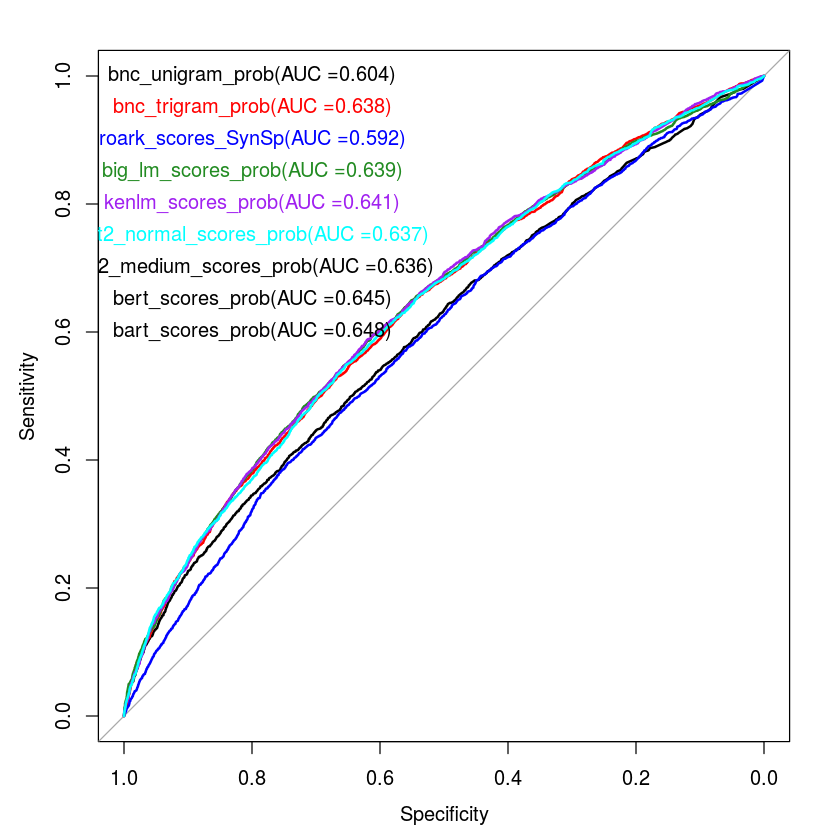

In [26]:
# plot all of the models
for (i in c(1:length(model_rocs))){
    model = model_rocs[[lm_predictors[i]]]
    if (i == 1){
        plot(model, col=colors[i]) 
    } else{
        plot(model, col=colors[i], add=T) 
    }
    text(x=.8, y=1-((i-1) * .05), labels= paste0(lm_predictors[i], 
    '(AUC =', round(auc(model), 3), ')'), col = colors[i]) 
}

In [27]:
prediction_by_model = do.call('rbind', lapply(1:length(model_rocs), function(i){
    model = lm_models[[lm_predictors[i]]]
    aic_score = round(AIC(model))
    roc = model_rocs[[lm_predictors[i]]]
    auc_score = round(auc(roc), 3)
    name = lm_nat_lang_names[i]
    return(data.frame(name, auc_score, aic_score))  
}))

prediction_by_model = prediction_by_model[order(prediction_by_model$aic),]
prediction_by_model

,name,auc_score,aic_score
,<fct>,<dbl>,<dbl>
9,Fill in dataset / BART,0.648,24089
8,BC+EW / BERT,0.645,24131
4,OBWB / Big LM,0.639,24169
5,DS / 5-gram,0.641,24178
2,BNC / Trigram,0.638,24221
6,WT / GPT-2,0.637,24225
7,WT / GPT-2 Medium,0.636,24232
1,BNC / Unigram,0.604,24596
3,PTB / Roark Parser,0.592,24853


In [ ]:
# Make this into a table

### Colorize responses

In [28]:
chosen_thread = subset(wdfs, thread_id == "0_5")
sentence_indices = unique(chosen_thread$sentence_index)
sentence_indices

[1] 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 400 401 402
[20] 403 404 405 406 407 408 409

In [29]:
colorizeSentence(wdfs, 383, format='latex')   

[1] "\\textcolor[HTML]{0CF200}{the} \\textcolor[HTML]{51AD00}{third} \\textcolor[HTML]{689600}{and} \\textcolor[HTML]{3DC100}{the} \\textcolor[HTML]{0CF200}{fourth} \\textcolor[HTML]{DB2300}{were} \\textcolor[HTML]{DD2100}{around} \\textcolor[HTML]{F20C00}{me}"

In [30]:
wdfs$me_predicted = predict(mixed_model, wdf, type='response')
#initial_sentences = subset(wdfs, upstream_pointer ==-1 & global_chain ==0)
chosen_thread = subset(wdfs, thread_id == "0_5")
sentence_indices = unique(chosen_thread$sentence_index)

colHTMLStore = list()
for (sid in sentence_indices){
    # target_index = unique(subset(initial_sentences, stimulus_id == sid)$sentence_index)
    colHTMLStore[[as.character(sid)]] = colorizeSentence(wdfs, sid, format='latex')   
    
    colorHTML = colorizeSentence(wdfs, sid, format='HTML')
    display_html(colorHTML)
}

write(paste0(colHTMLStore, collapse='\n \\\\ \n'), file = "figures/logisticRegression.txt")

the third and the fourth were around me

the third and the fourth were around him

the third and the fourth were around him

a third of the force go around him

a third of the force was downed

a third of the force was down

a third of the force was banned

a third of the force was banned

the third of the fourth was beans

the third or the fourth has been seen

the third or the fourth has been said

the third and fourth have been set

the third and fourth have been set

the third and fourth have been set

the third and fourth have been set

the 3rd and 4th have been set

how do you know the difference between hot and cold

how do you know the difference between hot and cold

how do you know the difference between hot and cold

how do you know the difference between hot and cold

how do you know the difference between hot and cold

how do you know the difference between hot and cold

how do you know the difference between hot and cold

how do you know the difference between hot and cold

how do you know the difference between hot and cold

how do you know the difference between hot and cold

In [31]:
mixed_model_nolms <- glmer(changed ~ sCounter + kpm_aoa_kup + kpm_nphon + kpm_nsyll + conc_conc_m + pld20 
+ (1|subject_id) + (1|upstream_subject_id)
,family=binomial(link='logit'),data=wdf, control=glmerControl(optimizer="bobyqa",
                            optCtrl=list(maxfun=2e5)))

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.formula(formula = change ~ prob, data = df)

Data: prob in 22482 controls (change 0) < 4808 cases (change 1).
Area under the curve: 0.6513


Area under the curve: 0.6513

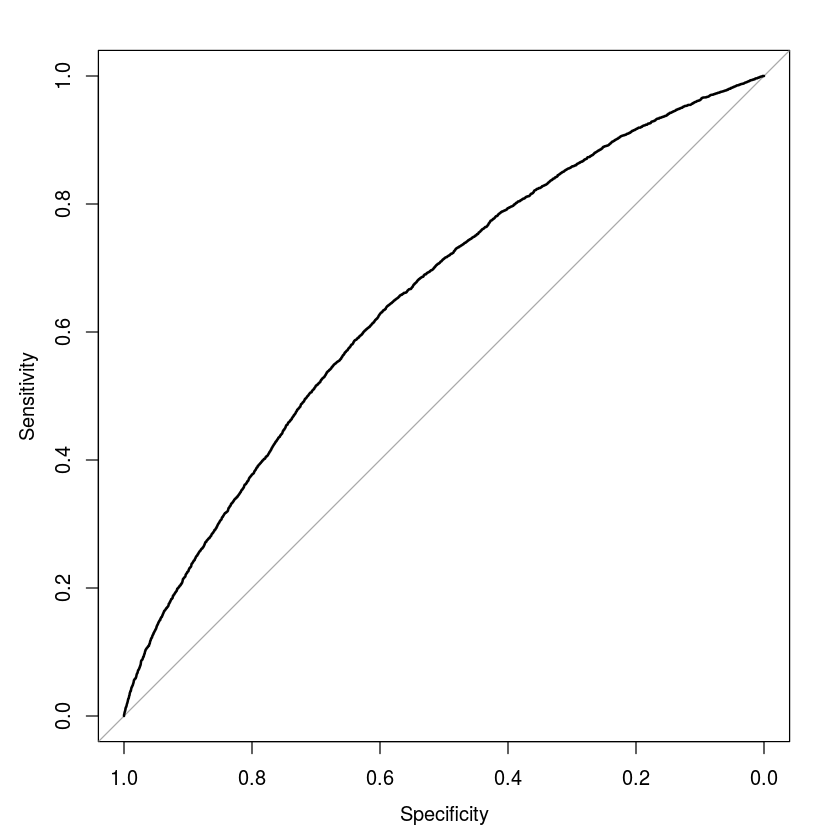

In [32]:
wdfs$nolms_predicted = predict(mixed_model_nolms, wdf, type='response')
df = data.frame(prob=wdfs$nolms_predicted, change=wdfs$change)
g <- roc(change ~prob, data = df)
print(plot(g))
auc(g)

In [33]:
# output the graph
source('telephone_analysis.R')

replacements = list()
replacements[['bnc_unigram_prob']] = 'BNC unigram surprisal'
replacements[['resid_bnc_trigram_prob']] = 'Residualized BNC trigram surprisal'
replacements[['resid_roark_scores_SynSp']] = 'Residualized Roark PCFG syntactic surprisal'
replacements[['resid_big_lm_scores_prob']] = 'Residualized Big LM surprisal'
replacements[['resid_kenlm_scores_prob']] = 'Residualized DS 5-gram surprisal'
replacements[['resid_gpt2_normal_scores_prob']] = 'Residualized GPT-2 surprisal'
replacements[['resid_gpt2_medium_scores_prob']] = 'Residualized GPT-2 medium surprisal'
replacements[['resid_bert_scores_prob']] = 'Residualized BERT surprisal'
replacements[['resid_bart_scores_prob']] = 'Residualized BART surprisal'
replacements[['sCounter']] = 'Position in sentence'
replacements[['kpm_aoa_kup']] = 'Age of acquisition'
replacements[['kpm_nphon']] = 'Number of phonemes'
replacements[['kpm_nsyll']] = 'Number of syllables'
replacements[['conc_conc_m']] = 'Concreteness'
replacements[['pld20']] = 'Phonological Neighborhood Density (PLD20)'
replacements[['upstream_subject_id']] = 'Speaker ID'
replacements[['subject_id']] = 'Listener ID'

modelName = "wordLevel"
wordLevelCaption = 'Mixed-effects logistic regression predicting whether a word will be transmitted successfully on the basis of its surprisal under various language models as well as other word properties. Significance of fixed-effects is computed following \\citet{satterthwaite1946}.'
wordLevelLabel = 'tab:wordlevel_lm'

modelToTable('mixed_logistic', modelName, mixed_model, replacements=replacements,file=paste0('LMs/',modelName,'_lm.tex'), 
        printVars = T, caption = wordLevelCaption, label = wordLevelLabel, where= 't')



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




 [1] "(Intercept)"                                
 [2] "BNC unigram surprisal"                      
 [3] "Residualized BNC trigram surprisal"         
 [4] "Residualized Roark PCFG syntactic surprisal"
 [5] "Residualized Big LM surprisal"              
 [6] "Residualized DS 5-gram surprisal"           
 [7] "Residualized GPT-2 surprisal"               
 [8] "Residualized GPT-2 medium surprisal"        
 [9] "Residualized BERT surprisal"                
[10] "Residualized BART surprisal"                
[11] "Position in sentence"                       
[12] "Age of acquisition"                         
[13] "Number of phonemes"                         
[14] "Number of syllables"                        
[15] "Concreteness"                               
[16] "Phonological Neighborhood Density (PLD20)"  
$names
[1] "subject_id"          "upstream_subject_id"

$sc
[1] 1

$useSc
[1] FALSE

$class
[1] "VarCorr.merMod"

[1] "Alisases for random variables"
[1] "Listener ID" "Speaker ID" 


Cross-validation 

In [ ]:
# propotion matches per user

In [34]:
(wdfs$code)

[1] "M" "D" "M" "M" "M" "M" "M" "S" "M" "M" "M" "D" "D" "M" "S" "M" "M" "M"
   [19] "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "M" "M" "M"
   [37] "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D"
   [55] "M" "M" "D" "D" "D" "M" "M" "M" "M" "D" "D" "M" "M" "S" "M" "M" "M" "M"
   [73] "M" "D" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "M" "S" "M" "M"
   [91] "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "D" "D" "M" "D" "D" "D" "D" "D"
  [109] "D" "M" "D" "D" "M" "M" "M" "S" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M"
  [127] "M" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [145] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [163] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "M"
  [181] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "M"
  [199] "M" "M" "M" "M" "D" "D" "D" "D" "M" "M" "M" "M" "S" "M" "D" "D" "D" "M"
  [217] "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "D" "D" "D" "D" "M" "M" "M" "M"
  [235] "M" "M" "M" "M" "M" "M" "M" "S" "M" "D" "D" "M" "M" "M" "M" "M" "M" "M"
  [253] "M" "S" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "D" "D" "D" "D" "D"
  [271] "M" "M" "M" "M" "M" "M" "S" "M" "M" "S" "M" "M" "D" "D" "D" "D" "M" "M"
  [289] "M" "M" "S" "M" "D" "M" "M" "D" "D" "D" "D" "D" "M" "M" "M" "D" "D" "D"
  [307] "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M"
  [325] "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "D" "D" "D" "D"
  [343] "M" "M" "M" "M" "D" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [361] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "M" "M" "S" "M" "M"
  [379] "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "M" "D" "M" "M" "M" "M" "M"
  [397] "M" "M" "S" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "S" "M" "D" "M"
  [415] "M" "M" "M" "D" "D" "M" "S" "M" "D" "D" "M" "D" "D" "M" "S" "M" "M" "M"
  [433] "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "M"
  [451] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "D" "M"
  [469] "M" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "S" "M" "D" "M"
  [487] "M" "M" "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M"
  [505] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [523] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "M"
  [541] "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "S" "M" "M" "S" "M" "M" "M"
  [559] "M" "M" "D" "D" "M" "M" "D" "D" "M" "M" "M" "D" "D" "D" "M" "M" "M" "M"
  [577] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [595] "M" "M" "M" "D" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [613] "M" "M" "M" "D" "D" "M" "M" "M" "M" "M" "M" "M" "D" "M" "M" "M" "M" "M"
  [631] "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [649] "M" "M" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [667] "M" "S" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "D" "M" "M" "M" "D" "D"
  [685] "M" "M" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [703] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M"
  [721] "M" "S" "M" "D" "D" "M" "M" "S" "M" "M" "M" "M" "M" "M" "S" "M" "D" "M"
  [739] "M" "M" "D" "D" "D" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "M" "M" "M"
  [757] "M" "S" "M" "D" "D" "D" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [775] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "S" "S" "M"
  [793] "D" "M" "M" "M" "M" "S" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "D" "M"
  [811] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D"
  [829] "M" "S" "M" "M" "M" "M" "M" "M" "M" "S" "M" "D" "D" "M" "M" "M" "M" "M"
  [847] "M" "M" "D" "D" "D" "M" "M" "S" "M" "M" "S" "M" "M" "D" "D" "M" "M" "M"
  [865] "M" "S" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M"
  [883] "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "M" "D" "D" "M" "S" "M"
  [9

In [35]:
names(wdfs)

[1] "bnc_unigram_index"                                  
  [2] "bnc_unigram_prob"                                   
  [3] "bnc_unigram_word"                                   
  [4] "bnc_trigram_index"                                  
  [5] "bnc_trigram_prob"                                   
  [6] "bnc_trigram_word"                                   
  [7] "roark_scores_prefix"                                
  [8] "roark_scores_word"                                  
  [9] "roark_scores_prefix.1"                              
 [10] "roark_scores_srprsl"                                
 [11] "roark_scores_SynSp"                                 
 [12] "roark_scores_LexSp"                                 
 [13] "roark_scores_ambig"                                 
 [14] "roark_scores_open"                                  
 [15] "roark_scores_rernk"                                 
 [16] "roark_scores_toprr"                                 
 [17] "roark_scores_stps"                                  
 [18] "big_lm_scores_Unnamed..0"                           
 [19] "big_lm_scores_prob"                                 
 [20] "big_lm_scores_word"                                 
 [21] "kenlm_scores_prob"                                  
 [22] "kenlm_scores_preceding"                             
 [23] "kenlm_scores_unk"                                   
 [24] "kenlm_scores_word"                                  
 [25] "gpt2_normal_scores_prob"                            
 [26] "gpt2_normal_scores_word"                            
 [27] "gpt2_medium_scores_prob"                            
 [28] "gpt2_medium_scores_word"                            
 [29] "bert_scores_prob"                                   
 [30] "bert_scores_word"                                   
 [31] "bart_scores_prob"                                   
 [32] "bart_scores_word"                                   
 [33] "sCounter"                                           
 [34] "sentence_index"                                     
 [35] "word"                                               
 [36] "code"                                               
 [37] "input_subject"                                      
 [38] "output_subject"                                     
 [39] "conc_bigram"                                        
 [40] "conc_conc_m"                                        
 [41] "conc_conc_sd"                                       
 [42] "conc_unknown"                                       
 [43] "conc_total"                                         
 [44] "conc_percent_known"                                 
 [45] "conc_subtlex"                                       
 [46] "conc_dom_pos"                                       
 [47] "kpm_alternative_spelling"                           
 [48] "kpm_freq_pm"                                        
 [49] "kpm_dom_pos_subtlex"                                
 [50] "kpm_nletters"                                       
 [51] "kpm_nphon"                                          
 [52] "kpm_nsyll"                                          
 [53] "kpm_lemma_highest_pos"                              
 [54] "kpm_aoa_kup"                                        
 [55] "kpm_perc_known"                                     
 [56] "kpm_aoa_kup_lem"                                    
 [57] "kpm_perc_known_lem"                                 
 [58] "kpm_aoa_bird_lem"                                   
 [59] "kpm_aoa_bristol_lem"                                
 [60] "kpm_aoa_cort_lem"                                   
 [61] "kpm_aoa_schock"                                     
 [62] "pic_ipa"                                            
 [63] "pic_ipa_ss_array"                                   
 [64] "pic_ipa_ss"                                         
 [65] "pic_ipa_n"                                          
 [66] "pic_ortho"                                          
 [67] "pic_ortho_ss_array"                

# Flag Behavior vs. Edit Behavior

In [36]:
propMatch = aggregate(code ~ output_subject, wdfs, function(x){sum(x == 'M') / length(x)})
names(propMatch) = c('user','propMatch')
numWords =  aggregate(code ~ output_subject, wdfs, function(x){numWords = length(x)})
names(numWords)  = c('user', 'numWords')
numSentences = aggregate(stimulus_id ~ input_subject, wdfs, function(x){length(unique(x))})
names(numSentences) = c('user','numSentencesNotFlagged')
wdfs_users = merge(merge(propMatch, numWords), numSentences)

In [39]:
flag_behavior = rbind(
    read.csv('output/180419_AMT_lengthLimitedGPU_flags.csv',
    stringsAsFactors=F),
    read.csv('output/180624_AMT_lengthLimitedGPU_flags.csv',
    stringsAsFactors=F)
)    

Warning message in file(file, "rt"):
“cannot open file 'output/180419_AMT_lengthLimitedGPU_flags.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [ ]:
stim_flags = subset(flag_behavior, flag_type == 'stimulus')

In [ ]:
flag_reasons = data.frame(table(stim_flags$reason))
flag_reasons = flag_reasons[order(flag_reasons$Freq, decreasing=T),]

In [ ]:
flags_per_user  = aggregate(reason ~ user, stim_flags, length)
names(flags_per_user) = c('user','numFlags')

In [ ]:
wdfs_users_with_flags = merge(wdfs_users, flags_per_user, all.x=T)
#add back users with 0-counts
wdfs_users_with_flags$numFlags[is.na(wdfs_users_with_flags$numFlags)] = 0
wdfs_users_with_flags$propFlags = wdfs_users_with_flags$numFlags / 
(wdfs_users_with_flags$numFlags + wdfs_users_with_flags$numSentencesNotFlagged)

In [ ]:
numFlagsAndUnflagged = sum(wdfs_users_with_flags$numSentencesNotFlagged
                          ) + sum(wdfs_users_with_flags$numFlags)

In [ ]:
# Proportion of inputs from other participants which were flagged
sum(wdfs_users_with_flags$numFlags)  / numFlagsAndUnflagged

In [ ]:
flag_reasons$propOfInputs = flag_reasons$Freq / numFlagsAndUnflagged
flag_reasons$propOfFlags = flag_reasons$Freq / sum(flag_reasons$Freq)
head(flag_reasons, n=10)

In [ ]:
lm1 = lm((1 - propMatch) ~ numFlags, subset(wdfs_users_with_flags, numWords > 25))
m = summary(lm1)
print(m)

In [ ]:
eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(R)^2~"="~r2~","~~italic(p)~"="~pval, 
         list(a = format(coef(m)[1], digits = 2), 
              b = format(coef(m)[2], digits = 2), 
             r2 = round(m$adj.r.squared, 3),
            pval = unname(round(pf(m$fstatistic[1], m$fstatistic[2], m$fstatistic[3],
      lower.tail = FALSE), 3))
             ))

eq = as.character(as.expression(eq))               
eq

In [ ]:
p1= ggplot(subset(wdfs_users_with_flags, numWords > 25)) + geom_point(aes(x=propFlags, y= 1 - propMatch)
) + geom_smooth(aes(x=propFlags, y=1 - propMatch), method='gam') + ylab(
'Proportion of Words Changed By Partcipant\n(Participant Accepted Sentences)') + xlab(
'Proportion of Input Sentences Flagged by Participant\n(Participant Rejected Sentences)'
) + theme_classic() + annotate("text", x = .4, y = .4, label = eq, parse = TRUE, 
    color='red', size=5)
p1 = ggMarginal(p1, type="histogram")
print(p1)

In [ ]:
ggsave( 'figures/wordChangesVsFlags.pdf', plot= p1, width=6, height=6)
ggsave( 'figures/wordChangesVsFlags.png', plot= p1, width=6, height=6)